# Exercise 3: 1DCNN for human activity classification

Download the dataset from the [Google Drive link](https://drive.google.com/file/d/1BDLcjJBjMxmY23cLBOTo-pEBubwy1qq7/view?usp=share_link)

# Description

Human Activity Recognition dataset is built from the recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors. In this notebook we train the 1-dimensional convolutional neural network to predict the type of human acivity: Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying. To implement the model, we use PyTorch library.

# Imports

In [1]:
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# Utilities

In [2]:
def to_categorical(y, num_classes=None, dtype='float32'):
  """Converts a class vector (integers) to binary class matrix.
  E.g. for use with categorical_crossentropy.
  # Arguments
      y: class vector to be converted into a matrix
          (integers from 0 to num_classes).
      num_classes: total number of classes.
      dtype: The data type expected by the input, as a string
          (`float32`, `float64`, `int32`...)
  # Returns
      A binary matrix representation of the input. The classes axis
      is placed last.
  # Example
  ```python
  # Consider an array of 5 labels out of a set of 3 classes {0, 1, 2}:
  > labels
  array([0, 2, 1, 2, 0])
  # `to_categorical` converts this into a matrix with as many
  # columns as there are classes. The number of rows
  # stays the same.
  > to_categorical(labels)
  array([[ 1.,  0.,  0.],
          [ 0.,  0.,  1.],
          [ 0.,  1.,  0.],
          [ 0.,  0.,  1.],
          [ 1.,  0.,  0.]], dtype=float32)
  ```
  """

  y = np.array(y, dtype='int')
  input_shape = y.shape
  if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
    input_shape = tuple(input_shape[:-1])
  y = y.ravel()
  if not num_classes:
    num_classes = np.max(y) + 1
  n = y.shape[0]
  categorical = np.zeros((n, num_classes), dtype=dtype)
  categorical[np.arange(n), y] = 1
  output_shape = input_shape + (num_classes,)
  categorical = np.reshape(categorical, output_shape)
  return categorical

# Data Loading Routine

In [3]:
def load_file(filepath):
  '''Load a single .csv file.'''
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
  return dataframe.values

In [4]:
# load a list of files into a 3D array of [samples, timesteps, features]
def load_group(filenames, prefix=''):
  '''Load a list of files into a 3D array of [samples, features, timesteps].'''
  loaded = list()
  for name in filenames:
    data = load_file(prefix + name)
    loaded.append(data)
  # stack group so that features are the 3rd dimension
  loaded = np.dstack(loaded)
  # transpose dimensions for convenient CNN input
  # so that the last dimension corresponds to input channels (like for the image)
  loaded = np.transpose(loaded, (0, 2, 1))
  return loaded

In [5]:
def load_dataset_group(group, prefix=''):
  '''Loads the data for the whole group, i.e. train or test.'''
  filepath = prefix + group + '/Inertial Signals/'
  # load all 9 files as a single array
  filenames = list()
  # total acceleration
  filenames += ['total_acc_x_' + group + '.txt', 'total_acc_y_' + group + '.txt', 'total_acc_z_' + group + '.txt']
  # body acceleration
  filenames += ['body_acc_x_' + group + '.txt', 'body_acc_y_' + group + '.txt', 'body_acc_z_' + group + '.txt']
  # body gyroscope
  filenames += ['body_gyro_x_' + group + '.txt', 'body_gyro_y_' + group + '.txt', 'body_gyro_z_' + group + '.txt']
  # load input data
  X = load_group(filenames, filepath)
  # load class output
  y = load_file(prefix + group + '/y_' + group + '.txt')
  return X, y

In [6]:
def load_dataset(prefix='', val_frac=0.4):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'HARDataset/')

    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)

    val_idx = np.random.choice([True, False], size=len(testy), p=[val_frac, 1-val_frac])
    valX, valy = testX[val_idx, :], testy[val_idx, :]
    testX, testy = testX[~val_idx, :], testy[~val_idx, :]

    print(trainX.shape, trainy.shape)
    print(valX.shape, valy.shape)
    print(testX.shape, testy.shape)

    return trainX, trainy, valX, valy, testX, testy

In [11]:
trainX, trainy, valX, valy, testX, testy = load_dataset('')

/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' 

(7352, 9, 128) (7352, 6)
(1134, 9, 128) (1134, 6)
(1813, 9, 128) (1813, 6)


/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)


# PyTorch DataSets and DataLoaders

Convenient way to pass the data to PyTorch model is torch.utils.data.DataLoader. DataLoader can iterate over the torch.utils.data.Dataset.

In [13]:
class HumanActivityDataset(Dataset):
  def __init__(self, X, y, device):
    self.X = torch.tensor(X).to(device)
    self.y = torch.tensor(y).to(device)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [14]:
def create_datasets(path, device='cpu'):
  trainX, trainy, valX, valy, testX, testy = load_dataset(path)
  train_dataset = HumanActivityDataset(trainX, trainy, device)
  val_dataset = HumanActivityDataset(valX, valy, device)
  test_dataset = HumanActivityDataset(testX, testy, device)

  return train_dataset, val_dataset, test_dataset

In [15]:
def create_dataloaders(datasets, batch_size=64):
  train_dataset, val_dataset, test_dataset = datasets

  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  d_info = f"train_size: {len(train_dataloader)}\n"
  d_info += f"validation_size: {len(val_dataloader)}\n"
  d_info += f"test_size: {len(test_dataloader)}"
  print(d_info)

  return train_dataloader, val_dataloader, test_dataloader

In [16]:
datasets = create_datasets('')
train_dataloader, val_dataloader, test_dataloader = create_dataloaders(datasets, batch_size=64)

/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/var/folders/6w/sv2ydg0d1c9c44jfs3pkt36w0000gn/T/ipykernel_80717/58810182.py:3: FutureWarning: The 'delim_whitespace' 

(7352, 9, 128) (7352, 6)
(1197, 9, 128) (1197, 6)
(1750, 9, 128) (1750, 6)
train_size: 115
validation_size: 19
test_size: 28


# PyTorch 1D CNN model

In [17]:
class ConvNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(9, 32, kernel_size=3),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.MaxPool1d(10))
        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3),
            nn.ReLU(),)
        self.layer3 = nn.Flatten()
        self.layer4 = nn.Sequential(
            nn.Linear(640,100),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Linear(100,6),
            nn.Softmax())

    def forward(self, x):
      out = self.layer1(x)
      out = self.layer2(out)
      out = self.layer3(out)
      out = self.layer4(out)
      out = self.layer5(out)
      return out

# Trainer class for PyTorch model

In [18]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        n_epochs=20,
        criterion=nn.CrossEntropyLoss(),
        model_name='best_model',
        device='cpu'
    ):
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.n_epochs = n_epochs
        self.criterion = criterion

        # adding time_stamp to model name to make sure the save models don't overwrite each other,
        # you can customize your own model name with hyperparameters so that you can reload the model more easily
        time_stamp = time.strftime("%m%d%H%M%S")
        self.model_path = f'models/{model_name}_{time_stamp}.pt'

        self.losses = {split: [] for split in ['train', 'eval', 'test']}

    def compute_loss(self, x, y, model=None):
        # y = y.view(-1)
        y_pred = self.model(x.float())
        # y_pred = y_pred.view(-1)
        # loss = self.criterion(y, torch.max(y_pred, 1)[1])
        loss = self.criterion(y_pred, y)
        return loss, y_pred, y

    def train_epoch(self, loader):
        self.model.train()
        # batch losses
        b_losses = []
        for x, y in loader:
            # Setting the optimizer gradient to Zero
            self.optimizer.zero_grad()
            x.to(torch.device(self.device))
            y.to(torch.device(self.device))

            loss, pred, target = self.compute_loss(x, y)

            # Backpropagate the training loss
            loss.backward()
            self.optimizer.step()
            b_losses.append(loss.detach().numpy())

        # aggregated losses across batches
        agg_loss = np.sum(b_losses) / len(loader)
        self.losses['train'].append(agg_loss)
        return agg_loss

    # decorator, equivalent to with torch.no_grad():
    @torch.no_grad()
    def eval_epoch(self, loader, split='eval'):
        self.model.eval()
        # batch losses
        b_losses = []
        for x, y in loader:
            x.to(torch.device(self.device)).float()
            y.to(torch.device(self.device)).float()

            loss, pred, target = self.compute_loss(x, y)

            b_losses.append(loss.detach().numpy())

        # aggregated losses across batches
        agg_loss = np.sum(b_losses) / len(loader)
        self.losses[split].append(agg_loss)
        return agg_loss

    def fit(self, loaders):
        print(f"Training model for {self.n_epochs} epochs...")
        train_loader, eval_loader, test_loader = loaders
        train_start = time.time()

        start_epoch = 0
        best_eval_loss = np.inf

        for epoch in range(start_epoch, self.n_epochs):
            epoch_start = time.time()

            train_loss = self.train_epoch(train_loader)
            eval_loss = self.eval_epoch(eval_loader, split='eval')
            test_loss = self.eval_epoch(test_loader, split='test')

            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss
                self.save(self.model, self.model_path)

            s = (
                f"[Epoch {epoch + 1}] "
                f"train_loss = {train_loss:.5f}, "
                f"eval_loss = {eval_loss:.5f}, "
                f"test_loss = {test_loss:.5f}"
            )

            epoch_time = time.time() - epoch_start
            s += f" [{epoch_time:.1f}s]"
            print(s)

        train_time = int(time.time() - train_start)

        print(f'Task done in {train_time}s')

    @torch.no_grad()
    def eval_accuracy(self, test_loader):
      print(f"Evaluating test accuracy...")
      best_model = self.load(self.model)
      best_model.eval()

      preds = []
      trues = []

      for x, y in tqdm(test_loader):
        x = x.to(self.device).float()
        y = y.to(self.device).float()

        y_pred = best_model(x)
        # _, y_pred, y_target = self.compute_loss(x, y)
        # print('y shape', y.shape)
        # print('y_pred shape', y_pred.shape)

        _, pred = torch.max(y_pred, 1)
        _, true = torch.max(y, 1)
        preds.append(pred.detach().cpu().numpy())
        trues.append(true.detach().cpu().numpy())

      preds = np.concatenate(preds, axis=0)
      trues = np.concatenate(trues, axis=0)

      # df = pd.DataFrame({
      #       'pred': preds,
      #       'true': trues,
      #       'accuray': np.sqrt((preds - trues)**2)
      #   })
      return preds, trues, (preds == trues).sum() / len(trues)

    def save(self, model, model_path=None):
        os.makedirs(f'models', exist_ok=True)
        if model_path is None:
            model_path = self.model_path
        torch.save(model.state_dict(), model_path)

    def load(self, model, model_path=None):
        """
        loads the prediction model's parameters
        """
        if model_path is None:
            model_path = self.model_path
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"Model {model.__class__.__name__} saved in {model_path} loaded to {self.device}")
        return model

    def plot_losses(self):
        """
        :param losses: dict with losses
        """
        linestyles = {
            'train': 'solid',
            'eval': 'dashed',
            'test': 'dotted',
        }
        for split, loss in self.losses.items():
            ls = linestyles[split]
            plt.plot(range(1, 1+len(loss)), loss, label=f'{split} loss', linestyle=ls)
            plt.yscale('log')

        plt.title("Training/Validation Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

# Training and evaluation

In [19]:
model = ConvNet1D().float()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [20]:
trainer = Trainer(
  model,
  optimizer,
  criterion=criterion,
  n_epochs=10,
)

trainer.fit((train_dataloader, val_dataloader, test_dataloader))

Training model for 10 epochs...


/Users/mathis/opt/anaconda3/envs/24ML/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


[Epoch 1] train_loss = 1.42423, eval_loss = 1.31793, test_loss = 1.33749 [1.3s]
[Epoch 2] train_loss = 1.14908, eval_loss = 1.21683, test_loss = 1.23056 [1.1s]
[Epoch 3] train_loss = 1.11322, eval_loss = 1.18565, test_loss = 1.20305 [0.9s]
[Epoch 4] train_loss = 1.10386, eval_loss = 1.20404, test_loss = 1.21678 [0.9s]
[Epoch 5] train_loss = 1.10074, eval_loss = 1.17566, test_loss = 1.19815 [0.9s]
[Epoch 6] train_loss = 1.09866, eval_loss = 1.16269, test_loss = 1.18764 [0.9s]
[Epoch 7] train_loss = 1.09498, eval_loss = 1.16827, test_loss = 1.18231 [1.6s]
[Epoch 8] train_loss = 1.09435, eval_loss = 1.14853, test_loss = 1.16924 [1.0s]
[Epoch 9] train_loss = 1.09094, eval_loss = 1.15263, test_loss = 1.17424 [0.9s]
[Epoch 10] train_loss = 1.09113, eval_loss = 1.15442, test_loss = 1.17148 [1.0s]
Task done in 10s


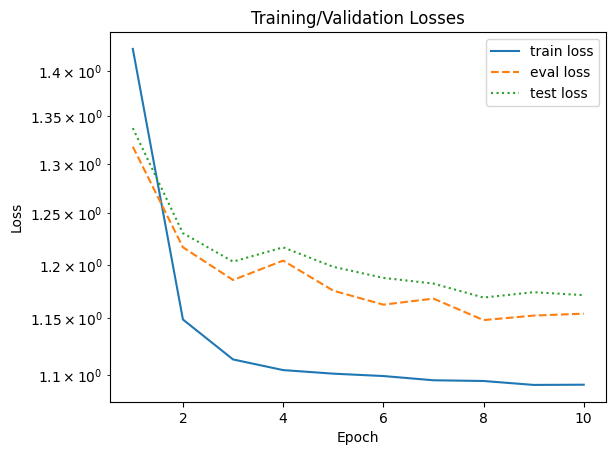

In [21]:
trainer.plot_losses()

In [22]:
predictions, trues, accuracy = trainer.eval_accuracy(test_dataloader)
print(f'\nBest accuracy: {accuracy:.4f}')

Evaluating test accuracy...
Model ConvNet1D saved in models/best_model_1017095158.pt loaded to cpu


100%|██████████| 28/28 [00:00<00:00, 150.22it/s]


Best accuracy: 0.8829
